# Digit Recognizer - Data Augmentation

Улучшение baseline модели с помощью аугментации данных

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Device: cuda


In [30]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (42000, 785)
Test shape: (28000, 784)


## Data Augmentation Strategy

Для рукописных цифр применяем:
- Небольшие повороты (±10°)
- Сдвиги (±10%)
- Масштабирование (90-110%)

Не применяем горизонтальное отражение — цифры станут нечитаемыми.

In [31]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [32]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.FloatTensor(image).unsqueeze(0) / 255.0
        
        if self.labels is not None:
            return image, self.labels[idx]
        return image

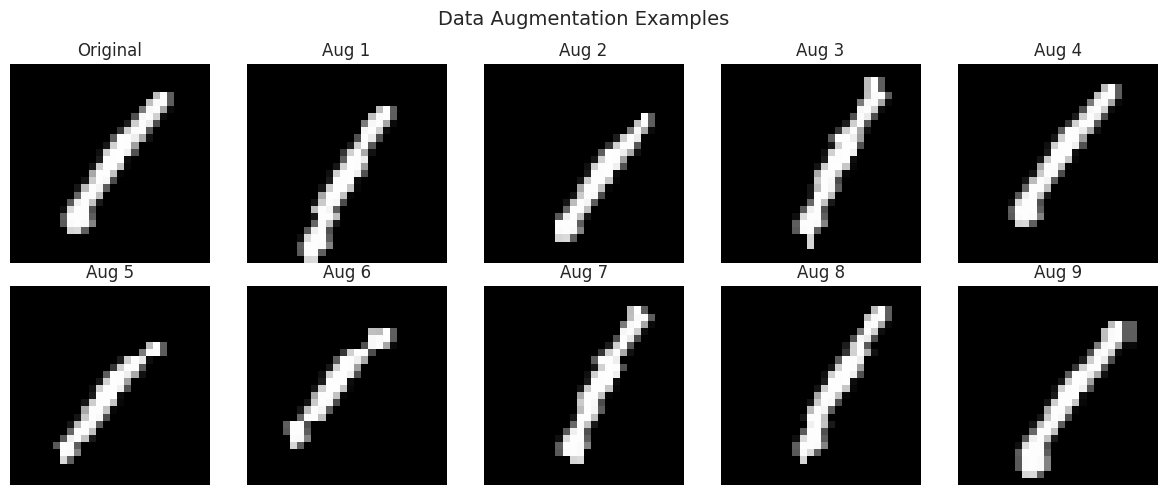

In [33]:
# Visualize augmentation
sample_image = train_df.iloc[0, 1:].values.reshape(28, 28).astype(np.uint8)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

axes[0, 0].imshow(sample_image, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i, ax in enumerate(axes.flatten()[1:]):
    augmented = train_transform(sample_image)
    ax.imshow(augmented.squeeze(), cmap='gray')
    ax.set_title(f'Aug {i+1}')
    ax.axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test = test_df.values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

print(f'Train: {X_train.shape}')
print(f'Val: {X_val.shape}')

Train: (37800, 784)
Val: (4200, 784)


In [35]:
train_dataset = MNISTDataset(X_train, y_train, transform=train_transform)
val_dataset = MNISTDataset(X_val, y_val, transform=val_transform)
test_dataset = MNISTDataset(X_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## CNN Model

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout1(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

In [37]:
model = CNN().to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f'\nTotal params: {total_params:,}')

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

Total params: 390,858


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

## Training

In [39]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

In [40]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_aug.pth')
    
    print(f'Epoch [{epoch+1}/{EPOCHS}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

print(f'\n🏆 Best Val Accuracy: {best_val_acc:.2f}%')

Epoch [1/40] | Train Loss: 0.5247 | Train Acc: 82.66% | Val Loss: 0.0741 | Val Acc: 97.50%
Epoch [2/40] | Train Loss: 0.2020 | Train Acc: 93.75% | Val Loss: 0.0600 | Val Acc: 98.12%
Epoch [3/40] | Train Loss: 0.1675 | Train Acc: 95.06% | Val Loss: 0.0535 | Val Acc: 98.62%
Epoch [4/40] | Train Loss: 0.1404 | Train Acc: 95.72% | Val Loss: 0.0519 | Val Acc: 98.55%
Epoch [5/40] | Train Loss: 0.1281 | Train Acc: 96.27% | Val Loss: 0.0444 | Val Acc: 98.67%
Epoch [6/40] | Train Loss: 0.1132 | Train Acc: 96.66% | Val Loss: 0.0415 | Val Acc: 98.79%
Epoch [7/40] | Train Loss: 0.1071 | Train Acc: 96.86% | Val Loss: 0.0299 | Val Acc: 99.17%
Epoch [8/40] | Train Loss: 0.0986 | Train Acc: 97.07% | Val Loss: 0.0322 | Val Acc: 99.05%
Epoch [9/40] | Train Loss: 0.0977 | Train Acc: 97.05% | Val Loss: 0.0324 | Val Acc: 99.05%
Epoch [10/40] | Train Loss: 0.0926 | Train Acc: 97.15% | Val Loss: 0.0289 | Val Acc: 99.02%
Epoch [11/40] | Train Loss: 0.0848 | Train Acc: 97.41% | Val Loss: 0.0287 | Val Acc: 99.1

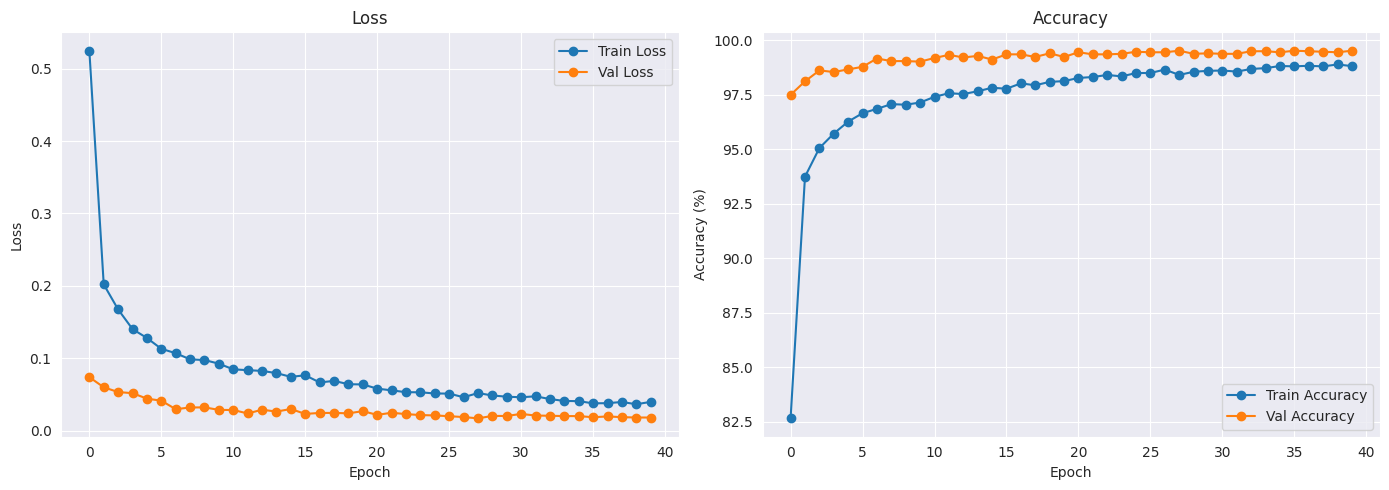

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Predictions & Submission

In [42]:
model.load_state_dict(torch.load('best_model_aug.pth'))
model.eval()

predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        predictions.extend(preds.cpu().numpy())

predictions = np.array(predictions)
print(f'Total predictions: {len(predictions)}')

Total predictions: 28000


In [ ]:
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission_aug_40.csv', index=False)
print('✅ submission_aug_40.csv created!')
submission.head(10)

## Results Comparison

| Model | Public Score |
|-------|-------------|
| Baseline (CNN+BatchNorm) | 0.99264 |
| Polar coordinates | 0.99067 |
| **Data Augmentation** | **0.99421** |